# SU(2) en 1+1 dim

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from tqdm import tqdm
import time
from multiprocessing import Pool
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [10]:
def Phi(arr):
    x, y, z, t = arr
    alpha = x + 1j*y
    beta = z + 1j*t
    return np.array([[alpha, -beta.conjugate()], [beta,alpha.conjugate()]])

def diffeo(t1,t2,t3):
    x1 = np.cos(t1)
    x2 = np.sin(t1) * np.cos(t2)
    x3 = np.sin(t1) * np.sin(t2) * np.cos(t3)
    x4 = np.sin(t1) * np.sin(t2) * np.sin(t3)
    arr = np.array([x1,x2,x3,x4])
    return Phi(arr)

def char(n,t1,t2,t3):
    if t1 != 0:
        return np.sin((n+1) * t1)/np.sin(t1)
    else:
        return n+1

def fourier(f,n,param):
    def integrand(t1,t2,t3):
        return 1/(2*np.pi**2) * f(diffeo(t1,t2,t3)) * char(n,t1,t2,t3) * np.sin(t1)**2 * np.sin(t2)
    return nquad(integrand,[[0,np.pi],[0,np.pi],[0,2*np.pi]])[0]

def f(U,param):
    return np.exp(2*param*np.real(U.trace()))

def Z(param,L):
    s = 0
    for n in range(4):
        s += (np.exp(-4*param)/(n+1) * fourier(lambda U:f(U,param),n,param))**(L**2)
    return s

In [18]:
betas = np.linspace(0,10,100)
#Z_vec = np.vectorize(lambda param:Z(param,10))

Z_list1 = []

# Create an iterable (e.g., a list or range)
my_list = range(len(betas))

# Wrap the iterable with tqdm
for item in tqdm(my_list):
    # Simulate some processing time
    #time.sleep(0.1)
    
    Z_list1.append(Z(betas[item],10))
    
    # This code will be executed for each item in the iterable


100%|█████████████████████████████████████████| 100/100 [06:35<00:00,  3.95s/it]


In [1]:
Z_arr1 = np.array(Z_list1)

plt.plot(betas,-np.log(Z_arr1))
plt.show()

energy = - betas[1::] * np.diff(np.log(Z_arr1))/np.diff(betas)
capacity = -betas[2::]**2 * np.diff(energy)/np.diff(betas[1::])
free = - 1/betas * np.log(Z_arr1)
pressure = - np.diff(free)/np.diff(betas)

plt.plot(betas[1::],energy)
plt.show()

#plt.plot(betas[2::],capacity)
#plt.show()

#plt.plot(betas,free)
#plt.show()

#plt.plot(betas[1::],pressure)
#plt.show()

#density = energy/betas[1::]**3
#temperature = 1/betas[1::]
#temperature = temperature[::-1]

#plt.plot(temperature,density[::-1])
#plt.show()

NameError: name 'np' is not defined

In [37]:
sigma1 = np.array([[0,1],[1,0]])
sigma2 = np.array([[0,-1j],[1j,0]])
sigma3 = np.array([[1,0],[0,-1]])

# Constants
N = 10  # Lattice size
n_iterations = 100000  # Number of Monte Carlo iterations
betas = np.linspace(0,10,100)
energies = []

# Define the action function
def calculate_action(lattice,beta):
    # Calculate the plaquette term in the action
    action_plaquette = 0.0
    for i in range(N):
        for j in range(N):
            plaq = np.matmul(lattice[i, j, 0], lattice[(i + 1) % N, j, 1])
            plaq = np.matmul(plaq, np.conj(lattice[i, (j + 1) % N, 0]).T)
            plaq = np.matmul(plaq, np.conj(lattice[i, j, 1]).T)
            action_plaquette += np.real(2 - np.trace(plaq))

    # Calculate the total action
    return 2 * beta * action_plaquette

def X(eps):
    r = np.random.uniform(low=-1/2,high=1/2,size=4)
    x0 =  np.sign(r[0]) * np.sqrt(1 - eps**2)
    x = eps * r[1:]/np.linalg.norm(r[1:])
    return x0 * np.eye(2) + 1j * (x[0] * sigma1 + x[1] * sigma2 + x[2] * sigma3)

# Perform the Monte Carlo simulation

for ind in tqdm(range(len(betas))):
    beta = betas[ind]

    # Initialize lattice with random SU(2) matrices
    lattice = np.zeros((N, N, 2, 2, 2), dtype=np.complex128)
    xvals = np.random.uniform(low=-10,high=10,size=(N,N,2,4))
    for i in range(N):
        for j in range(N):
            for k in range(2):
                xvec = xvals[i,j,k]
                xvec = xvec/(np.linalg.norm(xvec))
                arr = xvec[0] * np.eye(2) + 1j * (xvec[1] * sigma1 + xvec[2] * sigma2 + xvec[3] * sigma3)
                lattice[i,j,k] = arr
                
    # Apply periodic boundary conditions
    lattice[0, :, :] = lattice[N-1, :, :]
    lattice[:,0, :] = lattice[:, N-1, :]            

    action_before = calculate_action(lattice,beta)
    energy = []
        
    for iteration in range(n_iterations):
    
        # Choose a random lattice site and direction
        i = np.random.randint(N)
        j = np.random.randint(N)
        k = np.random.randint(2)

        # Generate a random SU(2) matrix
        su2_matrix = X(0.5)
        
        new_lattice = lattice.copy()

        # Update the gauge field at the chosen site
        new_lattice[i, j, k] = np.matmul(su2_matrix, new_lattice[i, j, k])
        
        # Apply periodic boundary conditions
        new_lattice[0, :, :] = new_lattice[N-1, :, :]
        new_lattice[:,0, :] = new_lattice[:, N-1, :]

        # Calculate the action after the update
        action_after = calculate_action(new_lattice,beta)

        # Decide whether to accept or reject the update
        if np.random.random() < np.exp(action_before - action_after):
            # Accept the update
            lattice = new_lattice
            action_before = action_after
            
        if iteration >= 9*n_iterations/10:
            energy.append(action_before)
            
    energies.append(np.array(energy).mean())

100%|██████████████████████████████████████| 100/100 [7:43:16<00:00, 277.96s/it]


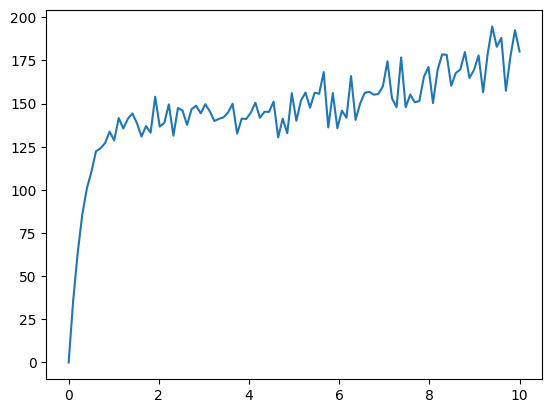

In [38]:
energies = np.array(energies)

plt.plot(betas,energies)

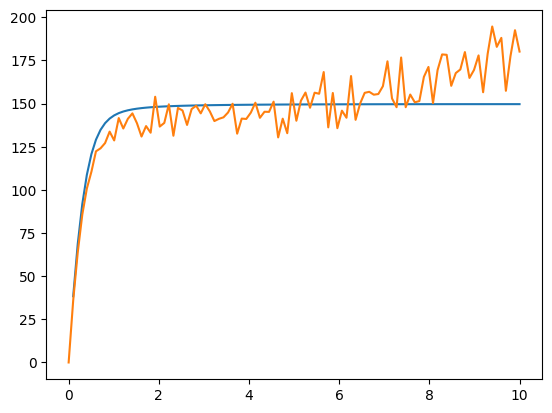

In [59]:
plt.plot(betas[1::],energy)
plt.plot(betas,energies)
#plt.plot(betas,-np.log(Z_arr1))

# SU(2) en 2+1 dim

In [ ]:
sigma1 = np.array([[0,1],[1,0]])
sigma2 = np.array([[0,-1j],[1j,0]])
sigma3 = np.array([[1,0],[0,-1]])

# Constants
N = 10  # Lattice size
n_iterations = 10000  # Number of Monte Carlo iterations
betas = np.linspace(0,10,100)
energies3D = []

def increment(coord,mu):
    delta = np.zeros(3)
    delta[abs(mu)] = 1
    return ((np.array(coord) + delta) % N).astype(int)

# Define the action function
def calculate_action(lattice,beta):
    # Calculate the plaquette term in the action
    action_plaquette = 0.0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(3):
                    for m in range(3):
                        coord = [i,j,k]
                        if l < m:
                            coord1 = increment(coord,l) 
                            coord2 = increment(coord,m)
                plaq = np.matmul(lattice[i, j, k, l], lattice[coord1[0], coord1[1], coord1[2], m])
                plaq = np.matmul(plaq, np.conj(lattice[coord2[0], coord2[1], coord2[2], l]).T)
                plaq = np.matmul(plaq, np.conj(lattice[i, j, k, m]).T)
                action_plaquette += np.real(3 - np.trace(plaq))

    # Calculate the total action
    return 2 * beta * action_plaquette

def X(eps):
    r = np.random.uniform(low=-1/2,high=1/2,size=4)
    x0 =  np.sign(r[0]) * np.sqrt(1 - eps**2)
    x = eps * r[1:]/np.linalg.norm(r[1:])
    return x0 * np.eye(2) + 1j * (x[0] * sigma1 + x[1] * sigma2 + x[2] * sigma3)

# Perform the Monte Carlo simulation

for ind in tqdm(range(len(betas))):
    beta = betas[ind]

    # Initialize lattice with random SU(2) matrices
    lattice = np.zeros((N, N, N, 3, 2, 2), dtype=np.complex128)
    xvals = np.random.uniform(low=-10,high=10,size=(N,N,N,3,4))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(3):
                    xvec = xvals[i,j,k,l]
                    xvec = xvec/(np.linalg.norm(xvec))
                    arr = xvec[0] * np.eye(2) + 1j * (xvec[1] * sigma1 + xvec[2] * sigma2 + xvec[3] * sigma3)
                    lattice[i,j,k] = arr
                
    # Apply periodic boundary conditions
    lattice[0, :, :, :] = lattice[N-1, :, :, :]
    lattice[:,0, :, :] = lattice[:, N-1, :, :]
    lattice[:, :, 0, :] = lattice[:, :, N-1, :] 

    action_before = calculate_action(lattice,beta)
    energy = []
        
    for iteration in range(n_iterations):
        
        # Choose a random lattice site and direction
        i = np.random.randint(N)
        j = np.random.randint(N)
        k = np.random.randint(N)
        l = np.random.randint(3)

        # Generate a random SU(2) matrix
        su2_matrix = X(0.5)
        
        new_lattice = lattice.copy()

        # Update the gauge field at the chosen site
        new_lattice[i, j, k, l] = np.matmul(su2_matrix, new_lattice[i, j, k, l])
        
        # Apply periodic boundary conditions
        lattice[0, :, :, :] = lattice[N-1, :, :, :]
        lattice[:,0, :, :] = lattice[:, N-1, :, :]
        lattice[:, :, 0, :] = lattice[:, :, N-1, :] 

        # Calculate the action after the update
        action_after = calculate_action(new_lattice,beta)

        # Decide whether to accept or reject the update
        if np.random.random() < np.exp(action_before - action_after):
            # Accept the update
            lattice = new_lattice
            action_before = action_after
            
        if iteration >= 9*n_iterations/10:
            energy.append(action_before)
            
    energies3D.append(np.array(energy).mean())

 25%|█████████▎                           | 25/100 [2:45:18<8:16:01, 396.82s/it]

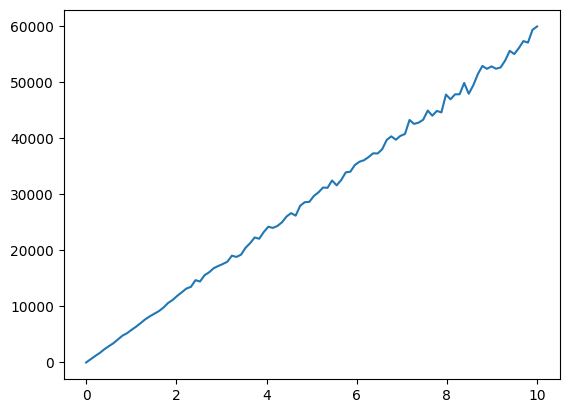

In [56]:
plt.plot(betas,energies3D)

In [ ]:
arr = np.linspace(0,1,10)
df = pd.DataFrame(data = arr)